In [569]:
from SloppyCell.ReactionNetworks import *
import numpy as np
import matplotlib.pyplot as plt
import itertools as it
import conditions as cnd

In [570]:
## load full network and set dynamic vars
net_full = IO.from_SBML_file('../model/model.xml', id='net_full')
dyn_vars =  ['paurb', 'pmelt_bub1','pmelt_bub1_pp2a', 'pmelt', 'rvsf', 'rvsf_pp1']
nonvars = list(set(net_full.dynamicVars.keys()) - set(dyn_vars))
for key in nonvars:
    net_full.set_var_constant(key, is_constant=True)
    net_full.set_var_optimizable(key, is_optimizable=False)
for var in ['pp1_tot', 'bub1_tot', 'pp2a_tot', 'kln1_tot', 'aurb_tot']:
    net_full.set_var_optimizable(var, False)

In [571]:
## generate all possible models
## ids are strings of 1/0 indicating presence/absence of reactions
phospho_pars = [
    ['kdp_rvsf_pp1', 'kdp_rvsf_pp2a'],
     ['kp_aurb_bub1','kp_aurb_aurb'],
     ['kdp_aurb_pp1','kdp_aurb_pp2a']]
nets = {}
#alf = ['01','10','11']
alf = ['11']
net_iterator = it.product(alf,repeat=3)
for n_i in net_iterator:
    id = ''.join(n_i)
    net_it = net_full.copy(new_id='net_'+id)
    for i in range(len(n_i)):
        pars = phospho_pars[i]
        for j in range(len(n_i[i])):
            val = float(n_i[i][j])
            net_it.set_var_ic(pars[j], val)
            net_it.set_var_optimizable(pars[j], bool(val))
    nets[id] = net_it

In [590]:
wirings = dict()
for id, net in nets.items():
    wiring = cnd.wiring(net, id)
    for m,m_data in cnd.data.items():
        for i,data in m_data.items():
            wiring.add_condition(cnd.mutants[m], cnd.interventions[i], data, cnd.sf[m][i])
    wirings[id] = wiring
    

In [593]:
w = wirings['111111']
w.add_model(['dkard_ic'], 'test_ic')
m = w.models['test_ic']

In [594]:
params = KeyedList()
for p,val in w.nets['dkard_ic'].optimizableVars.items():    
    params.setByKey(p, 1)
    res = Residuals.PriorInLog(p+'_prior', p, np.log(val.initialValue), np.log(np.sqrt(100)))
    m.AddResidual(res)
params

KeyedList([('kb_rvsf_pp1', 1), ('kd_rvsf_pp1', 1), ('kb_pmelt_bub1', 1), ('kd_pmelt_bub1', 1), ('kp_melt', 1), ('kdp_melt', 1), ('kp_rvsf', 1), ('kdp_rvsf_pp2a', 1), ('kdp_rvsf_pp1', 1), ('kp_aurb_bub1', 1), ('kp_aurb_aurb', 1), ('kdp_aurb_pp1', 1), ('kdp_aurb_pp2a', 1)])

In [595]:
params_ic_opt = Optimization.fmin_lm_log_params(m, params, maxiter=200, disp=True)

Iteration number 0
Current cost 16.0
Move 1 gives cost of 16.0
Move 2 gives cost of  16.0
 Optimization terminated successfully.
 Current function value: 16.000000
 Iterations: 1
 Function evaluations: 4
 Gradient evaluations: 2


In [580]:
e = m.exptColl['dkard_ic']
m.calcColl

KeyedList([('dkard_ic', <SloppyCell.ReactionNetworks.Network_mod.Network instance at 0x11ab83dd0>)])

In [587]:
net_wt = w.nets['wt_ic'].copy('wt')
net_dkard = w.nets['dkard_ic'].copy('dkard')
traj_wt = Dynamics.integrate(net_wt, [0,1200], params = params_ic_opt)
traj_dkard = Dynamics.integrate(net_dkard, [0,1200], params = params_ic_opt)

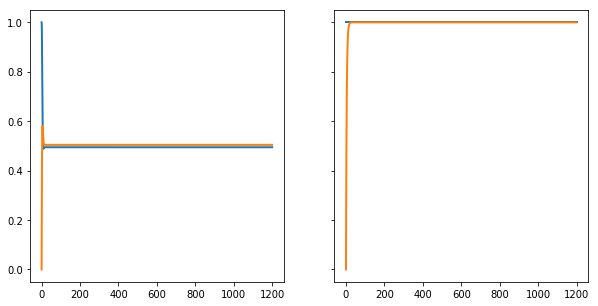

In [588]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5),sharey=True)
ax1.plot(traj_wt.timepoints, traj_wt.get_var_traj('prvsf'))
ax1.plot(traj_wt.timepoints, traj_wt.get_var_traj('pmelt_tot'))
ax2.plot(traj_dkard.timepoints, traj_dkard.get_var_traj('prvsf'))
ax2.plot(traj_dkard.timepoints, traj_dkard.get_var_traj('pmelt_tot'))

In [589]:
reload(cnd)

<module 'conditions' from 'conditions.py'>

In [501]:
net_dkard.optimizableVars.keys()

['kb_rvsf_pp1',
 'kd_rvsf_pp1',
 'kb_pmelt_bub1',
 'kd_pmelt_bub1',
 'kp_melt',
 'kdp_melt',
 'kp_rvsf',
 'kdp_rvsf_pp2a',
 'kdp_rvsf_pp1',
 'kp_aurb_bub1',
 'kp_aurb_aurb',
 'kdp_aurb_pp1',
 'kdp_aurb_pp2a']